# hERG

## 1. Importing modules and functions
         
    

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
import csv
import pickle

from stats import *
from calc_rdkit import *
from rename_descriptors import *
from BalanceBySim import *

from math import floor
from collections import Counter

from rdkit import Chem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import AllChem, Descriptors, Crippen, MolSurf, Lipinski, Fragments, EState, GraphDescriptors
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import permutation_test_score, StratifiedKFold
from sklearn import metrics
from sklearn.externals import joblib

def warn(*args, **kwargs):
    pass  # to suppress sklearn warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%reload_ext autoreload
%autoreload 2
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

## 2. Load data

Select data type in `mol_input`:
1. SDF
1. CSV
1. SMILES

Original data:  (6824, 9)
Kept data:  (6824, 9)


,Compound_name,IC50_nM,ID,InChIKey,Outcome,Mol,SMILES,Standard Relation,pIC50
0,21,20700.0,,AABBLHFMQYNECK-UHFFFAOYSA-N,0,,Cc1c(C(O)CN2CCC3(CC2)CC(=O)N(c2ccc(S(C)(=O)=O)cn2)C3)ccc2c1COC2=O,'=',4.689619755002897

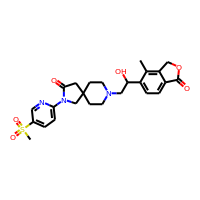

In [8]:
# Set file path and format
file = 'curated_data/herg_curated.sdf.gz'
mol_input = 1

# Read SDF
if mol_input == 1:
    sdfInfo = dict(smilesName='SMILES', molColName='ROMol')
    moldf = PandasTools.LoadSDF(file, **sdfInfo)
    print('Original data: ', moldf.shape)
    # Rename ROMol
    moldf = moldf.rename(columns={'ROMol': 'Mol'})
    # Remove missing RDKit molecules
    moldf = moldf[pd.notnull(moldf['Mol'])]
    if 'StandardizerResult' in moldf.columns:
        moldf = moldf.drop(columns='StandardizerResult')
    # Columns
    print('Kept data: ', moldf.shape)
    moldf.head(1)
    
# Read CSV
elif mol_input == 2:
    moldf = pd.read_csv(file, sep=',', encoding='utf-8')
    # Add Mol column
    PandasTools.AddMoleculeColumnToFrame(moldf, smilesCol='SMILES_ISO', molCol='Mol', includeFingerprints=False)
    # Remove missing RDKit molecules
    moldf = moldf[pd.notnull(moldf['Mol'])]
    # Columns
    print(moldf.shape)
    moldf.head(1)
    
# SMILES string
elif mol_input == 3:
    moldf = pd.DataFrame(columns=['Compound_name', 'SMILES'])
    moldf = moldf.append({'SMILES': 'C[N](C)(C)=[C]1=CC=CC=C1', 'Compound_name': 'Test'}, ignore_index=True)
    # Add Mol column
    PandasTools.AddMoleculeColumnToFrame(moldf, smilesCol='SMILES', molCol='Mol', includeFingerprints=False)
    # Remove moléculas sem esrtutura no RDKit
    moldf = moldf[pd.notnull(moldf['Mol'])]
    # Columns
    print(moldf.shape)
    moldf.head(1)

## 3. Clean data columns

,Mol,Compound_name,Outcome
0,,21,0

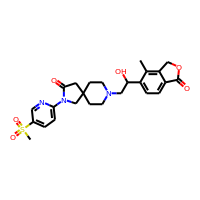


 Problematic structures: 
 []


In [9]:
moldf = moldf[['Mol', 'Compound_name', 'Outcome']]
moldf.head(1)
  
from molvs.validate import Validator
fmt = '%(asctime)s - %(levelname)s - %(validation)s - %(message)s'
validator = Validator(log_format=fmt)
print('\n Problematic structures: \n', validator.validate(moldf))

## 4. Data balancing (?)

In [10]:
# Data shape
# Print shape
print('Training set shape: %s' % Counter(moldf['Outcome']))

Training set shape: Counter({'0': 3436, '1': 3388})


In [12]:
# Balance data using 1/2 similarity and 1/2 random
moldf = BalanceBySim(moldf, 2)

# Print shape
print('Training set shape: %s' % Counter(moldf['Outcome'].loc[moldf['Set'] == 'train']))
print('External set shape: %s' % Counter(moldf['Outcome'].loc[moldf['Set'] == 'ext']))

Training set shape: Counter({0: 3389, 1: 3388})
External set shape: Counter({0: 47})


## 5. Calculate descriptors

### 5.1 Calculate whole-molecule RDKit descriptors

In [13]:
moldf_train = moldf.loc[moldf['Set'] == 'train']

##### Calculate descriptors using custom function

In [14]:
rdkit_train = moldf_train.Mol.apply(calc_rdkit)
rdkit_train = rename_descriptors(rdkit_train)
rdkit_train = rdkit_train.astype(float).round(2)
rdkit_train.head()

,MolLogP,MolMR,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,FractionCSP3,HeavyAtomMolWt,MaxAbsPartialCharge,MaxPartialCharge,MinAbsPartialCharge,MinPartialCharge,MolWt,NumRadicalElectrons,NumValenceElectrons,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_ArN,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_COO,fr_COO2,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_HOCCN,fr_imidazole,fr_imide,fr_Imine,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_NH0,fr_NH1,fr_NH2,fr_Nhpyrrole,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_SH,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,TPSA
0,2.02,127.68,1.17,1.91,2.57,0.48,470.36,0.46,0.34,0.34,-0.46,499.59,0.0,186.0,12.81,12.81,0.00,-3.34,15.94,23.11,0.0,28.79,30.89,48.88,12.26,17.03,12.99,9.88,4.74,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.21,1283.03,24.96,19.86,20.68,16.56,11.73,13.62,9.98,12.00,7.66,8.76,5.47,6.03,-2.82,81259715.65,23.90,8.69,4.46,35.0,1.0,9.0,0.0,3.0,3.0,1.0,1.0,2.0,8.0,1.0,10.0,5.0,0.0,2.0,2.0,5.0,204.18,14.74,12.42,9.84,5.91,0.00,5.97,9.69,18.20,0.00,0.0,6.07,67.60,37.53,16.56,4.90,5.82,0.00,0.00,67.72,25.98,12.34,52.41,35.36,0.00,0.00,0.0,27.85,27.53,0.0,9.88,5.41,43.79,37.33,52.72,0.0,0.00,117.11
1,2.01,120.50,1.19,1.90,2.52,0.64,419.72,0.50,0.25,0.25,-0.50,452.98,0.0,172.0,12.91,12.91,0.10,-0.25,0.00,9.59,0.0,23.96,27.94,51.99,13.18,20.10,4.90,10.22,26.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.56,797.96,22.54,18.53,19.28,14.82,10.76,11.14,8.43,8.83,6.40,6.73,4.51,4.67,-2.03,7356272.25,23.63,10.52,5.81,31.0,3.0,8.0,0.0,2.0,2.0,1.0,0.0,1.0,6.0,2.0,9.0,6.0,0.0,2.0,2.0,3.0,188.52,30.32,5.75,0.00,5.91,5.91,0.00,9.59,0.00,0.00,0.0,11.60,31.25,52.82,35.53,15.79,5.69,5.75,11.60,80.70,9.53,5.92,36.54,12.13,5.02,0.00,0.0,19.06,29.10,0.0,15.12,5.92,38.33,52.68,22.72,0.0

##### Remove constant and near constant variables

In [15]:
rdkit_train = rdkit_train.dropna(axis=1, how='any')
rdkit_train = rdkit_train.fillna(0)

# Def low variance filter (10% threshold)
def variance_filter(data, threshold=0.1):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# Apply filter
rdkit_train = variance_filter(rdkit_train)

##### Remove correlated variables

In [16]:
correlated_features = set()  
correlation_matrix = rdkit_train.corr()

for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

rdkit_train.drop(labels=correlated_features, axis=1, inplace=True)

# Drop descriptors found to be problematic
rdkit_train = rdkit_train.drop(columns='Ipc')

rdkit_train.shape

(6777, 88)

### 4.2 Calculate morgan fingerprints with 2048 bits and radius 3

##### Calculate morgan fingerprints with 2048 bits and radius 3

In [17]:
def calcfp(mol,funcFPInfo=dict(radius=3, nBits=2048, useFeatures=False, useChirality = False)):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('Bit_')
    return fp

In [18]:
# Training set
morgan_train = moldf_train.Mol.apply(calcfp)
morgan_train.shape

(6777, 2048)

### 4.3 Set the dependent variable and print the class size

Number of compounds in each class : [(0, 3389), (1, 3388)]
Total number of cpds :  6777


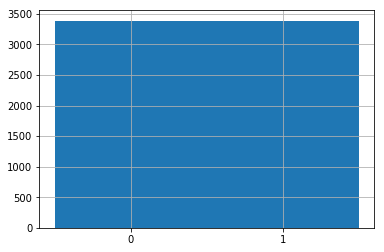

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Encode string to integer
outcomes = (np.unique(moldf_train['Outcome']))
le.fit(list(set(outcomes)))
y = le.transform(moldf_train['Outcome'])

# Encode string to integer
S = moldf_train['Outcome']
info = {}
for i, cls in enumerate(S.unique()):
    info.update({cls: i})
    S = S.replace(cls, i)
    
# Print sizes
print('Number of compounds in each class : %s' % Counter(y).most_common())
print('Total number of cpds : ', len(y))

ax = S.hist(bins=np.arange(-0.5, 2)) #set up number of classes
ax.set_xticks(range(0, 2))
info;

### 4.4 Concat RDKIt descriptors and morgan for training set

In [20]:
X = pd.concat([rdkit_train, morgan_train], axis=1, join='inner')
X.shape

(6777, 2136)

### 4.5 Define train and test set

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

## 5. Model building

### 5.1 Modeling data

##### Find best parameters

In [22]:
# Number of trees in random forest
n_estimators = [100, 250, 500, 750, 1000]
max_features = ['auto', 'sqrt']
criterion = ['gini', 'entropy']

# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'criterion': criterion}

# setup model building
rf = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1, cv=5, verbose=1)
rf.fit(X_train, y_train)
print()
print('Best params: %s' % rf.best_params_)
print('Score: %.2f' % rf.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 250, 500, 750, 1000], 'max_features': ['auto', 'sqrt'], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)


Best params: {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 500}
Score: 0.79


##### Find best parameters

In [23]:
rf_best = RandomForestClassifier(**rf.best_params_)
rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

##### 5-fold cross-validation

In [24]:
# Params
pred = []
ad = []
index = []
cross_val = StratifiedKFold(n_splits=5)

# Do 5-fold loop
for train_index, test_index in cross_val.split(X_train, y_train):
    
    fold_model = rf_best.fit(X_train.iloc[train_index], y_train[train_index])
    fold_pred = rf_best.predict(X_train.iloc[test_index])
    fold_ad = rf_best.predict_proba(X_train.iloc[test_index])
    pred.append(fold_pred)
    ad.append(fold_ad)
    index.append(test_index)

In [25]:
threshold_ad = 0.6

# Prepare results to export    
fold_index = np.concatenate(index)    
fold_pred = np.concatenate(pred)
fold_ad = np.concatenate(ad)
fold_ad = (np.amax(fold_ad, axis=1) >= threshold_ad).astype(str)
five_fold = pd.DataFrame({'Prediction': fold_pred,'AD': fold_ad}, index=list(fold_index))
five_fold.AD[five_fold.AD == 'False'] = np.nan
five_fold.AD[five_fold.AD == 'True'] = five_fold.Prediction
five_fold.sort_index(inplace=True)
five_fold['y_train'] = pd.DataFrame(y_train)
five_fold_ad = five_fold.dropna().astype(int)
coverage_5f = len(five_fold_ad) / len(five_fold)

# Print stats
cross_val_stats = pd.DataFrame(stats(five_fold.y_train, five_fold.Prediction))
cross_val_stats['Coverage'] = 1.0
print('Five-fold external cross validation: \n', cross_val_stats.to_string(index=False), '\n')
cross_val_stats_ad = pd.DataFrame(stats(five_fold_ad.y_train, five_fold_ad.AD))
cross_val_stats_ad['Coverage'] = round(coverage_5f, 2)
print('Five-fold external cross validation with 60% AD cutoff: \n', cross_val_stats_ad.to_string(index=False), '\n')

Five-fold external cross validation: 
  Accuracy  Kappa   CCR  Sensitivity   PPV  Specificity   NPV  Coverage
     0.78   0.57  0.78         0.77  0.79          0.8  0.77       1.0 

Five-fold external cross validation with 60% AD cutoff: 
  Accuracy  Kappa   CCR  Sensitivity   PPV  Specificity   NPV  Coverage
     0.85   0.69  0.85         0.84  0.85         0.85  0.84      0.77 



##### Predict test set

In [26]:
# Make predictions
test_set = rf_best.predict(X_test)
test_set_ad = rf_best.predict_proba(X_test)
test_set_ad = (np.amax(test_set_ad, axis=1) >= threshold_ad).astype(str)

# Prepare data
test_set = pd.DataFrame({'Prediction': test_set,'AD': test_set_ad})
test_set.AD[test_set.AD == 'False'] = np.nan
test_set.AD[test_set.AD == 'True'] = test_set.Prediction
test_set.sort_index(inplace=True)
test_set['y_test'] = pd.DataFrame(y_test)
test_set_ad = test_set.dropna().astype(int)
coverage_test = len(test_set_ad) / len(test_set)

# Print stats
test_set_stats = pd.DataFrame(stats(test_set.y_test, test_set.Prediction))
test_set_stats['Coverage'] = 1.0
print('Test set: \n', test_set_stats.to_string(index=False), '\n')
test_set_stats_ad = pd.DataFrame(stats(test_set_ad.y_test, test_set_ad.AD))
test_set_stats_ad['Coverage'] = round(coverage_test, 2)
print('Test set with AD: \n', test_set_stats_ad.to_string(index=False), '\n')

Test set: 
  Accuracy  Kappa   CCR  Sensitivity  PPV  Specificity   NPV  Coverage
     0.81   0.62  0.81         0.81  0.8         0.81  0.82       1.0 

Test set with AD: 
  Accuracy  Kappa   CCR  Sensitivity   PPV  Specificity   NPV  Coverage
     0.87   0.74  0.87         0.86  0.88         0.89  0.87      0.76 



##### Y-randomization

In [27]:
permutations = 20
score, permutation_scores, pvalue = permutation_test_score(rf_best, X_train, y_train,
                                                           cv=5, scoring='balanced_accuracy',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=24)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  5.1min remaining:   34.1s


True score =  0.78 
Y-randomization =  0.5 
p-value =  0.0476


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.1min finished


##### Save model

In [28]:
joblib.dump(rf_best, "model/rf_rdkit_morgan.pkl", compress=3)

['model/rf_rdkit_morgan.pkl']

##### Save descriptors

In [29]:
X_train.to_csv('descriptors/rdkit_morgan.csv.gz', compression='gzip')

### 6. Plot stats

In [30]:
# Export stats
all_stats = pd.concat([cross_val_stats, cross_val_stats_ad, test_set_stats, test_set_stats_ad], axis=0)
all_stats.set_index([['5-fold CV', '5-fold CV AD', 'Test set', 'Test set AD']], drop=True, inplace=True)

all_stats

,Accuracy,Kappa,CCR,Sensitivity,PPV,Specificity,NPV,Coverage
5-fold CV,0.78,0.57,0.78,0.77,0.79,0.80,0.77,1.00
5-fold CV AD,0.85,0.69,0.85,0.84,0.85,0.85,0.84,0.77
Test set,0.81,0.62,0.81,0.81,0.80,0.81,0.82,1.00
Test set AD,0.87,0.74,0.87,0.86,0.88,0.89,0.87,0.76


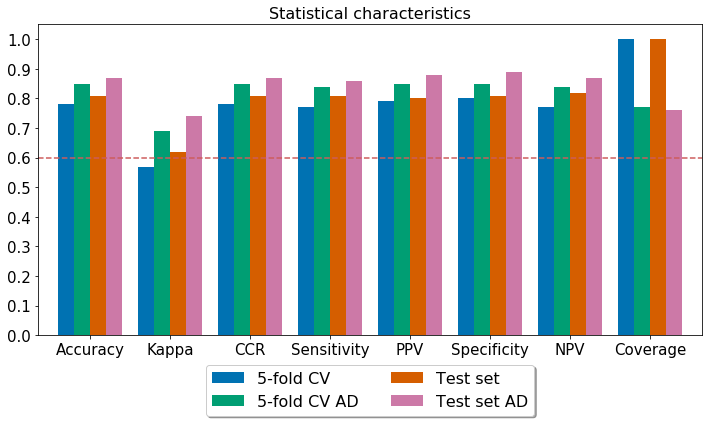

In [31]:
# Transpose stats
all_stats_t = all_stats.T
all_stats_t = all_stats_t.reset_index()
all_stats_t = all_stats_t.rename(columns={'index': 'Stats'})

# Make plot
plt.style.use('seaborn-colorblind')
fig, ax1 = plt.subplots(figsize=(10,6))

all_stats_t.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_xticklabels(labels=all_stats_t['Stats'].tolist(), fontsize=14, rotation=0)
ax1.axhline(y=.6, color='indianred', ls='dashed')# xmin=0.25, xmax=0.75)
ax1.legend_.remove()
plt.title('Statistical characteristics', fontsize=16)
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.tick_params(labelsize=15)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=16,
            loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True,
            shadow=True, ncol=2)
fig.tight_layout()

plt.savefig('statistics.png', bbox_inches='tight',
            transparent=False, format='png', dpi=300)
plt.show();

### 7. Variable importance

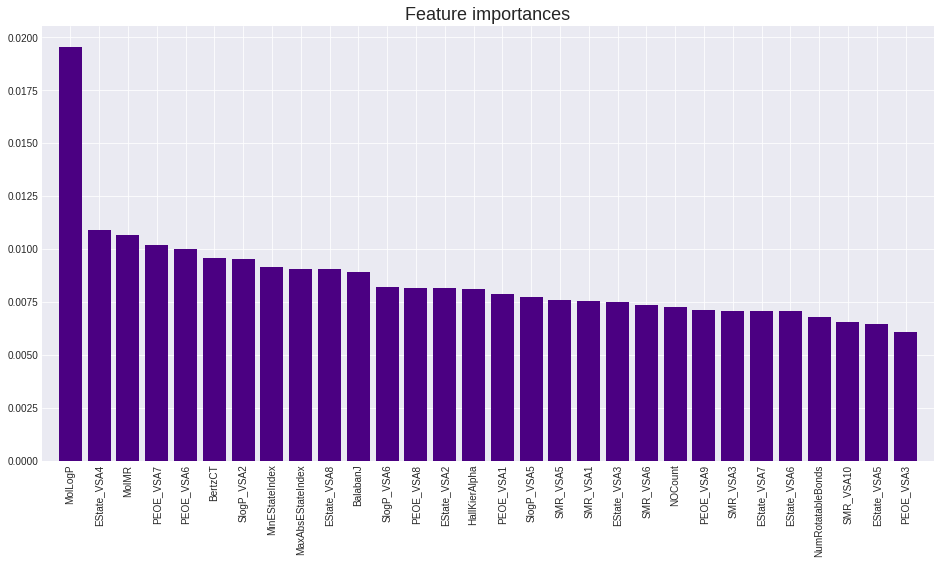

In [32]:
# Export feature importances
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
features = list(X_train)

# Get top 30 variables
top_var = []
for f in range(30):
    top_var.append(features[indices[f]])
    
# Plot the feature importances of the forest
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16,8))
plt.title('Feature importances', size=18)
plt.bar(np.arange(30), importances[indices[0:30]],
       color='indigo', align='center')
plt.xticks(np.arange(30), top_var, rotation=90)
plt.xlim([-1, 30])
plt.savefig('feature_importances.png', bbox_inches='tight',
           transparent=False, format='png', dpi=300)
plt.show();

In [33]:
# Print the feature ranking
var_imp = []
for f in range(30):
    var_imp.append({'Variable Index': indices[f], 'Variable': features[indices[f]], 'Importance': importances[indices[f]]})

var_imp = pd.DataFrame(var_imp)
var_imp.round(4)

,Importance,Variable,Variable Index
0,0.0196,MolLogP,0
1,0.0109,EState_VSA4,9
2,0.0107,MolMR,1
3,0.0102,PEOE_VSA7,66
4,0.0100,PEOE_VSA6,65
5,0.0096,BertzCT,40
6,0.0095,SlogP_VSA2,73
7,0.0091,MinEStateIndex,3
8,0.0091,MaxAbsEStateIndex,2
9,0.0091,EState_VSA8,13
